In [1]:
#!pip install --quiet --upgrade langchain-google-genai langgraph langchain-mcp-adapters langchain-openai langchain-google-genai langchain-anthropic

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
import re
import asyncio
import pandas as pd
from typing import List, Tuple, Dict, Any, Optional
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent
from langchain.chat_models import init_chat_model
from langchain.schema import AIMessage
from collections import defaultdict

class MultiDatabaseMCPGraphEvaluator:
    def __init__(
        self, 
        evaluation_prompt: str, 
        namespace: str = "graph",
        agent_model: str = "anthropic:claude-3-7-sonnet-latest",
        evaluation_llm: Optional[Any] = None,
        evaluation_model: str = "anthropic:claude-3-5-haiku-latest",
        evaluation_model_kwargs: Optional[Dict[str, Any]] = None,
        max_concurrent: int = 5,
        recursion_limit: int = 10
    ):
        """
        Initialize the Multi-Database MCP Graph Evaluator
        
        Args:
            evaluation_prompt: The prompt template for evaluating answers
            namespace: The namespace for the MCP server (default: "graph")
            agent_model: The model to use for the agent
            evaluation_llm: Pre-configured LLM instance for evaluation
            evaluation_model: The model to use for evaluation if evaluation_llm is None
            evaluation_model_kwargs: Additional kwargs for init_chat_model
            max_concurrent: Maximum number of concurrent evaluations (default: 5)
            recursion_limit: Maximum recursion limit for the agent (default: 10)
        """
        self.evaluation_prompt = evaluation_prompt
        self.namespace = namespace
        self.agent_model = agent_model
        self.max_concurrent = max_concurrent
        self.recursion_limit = recursion_limit
        
        # Store evaluators for each database
        self.evaluators = {}
        
        # Handle evaluation LLM
        if evaluation_llm is not None:
            self.llm = evaluation_llm
        else:
            model_kwargs = evaluation_model_kwargs or {}
            self.llm = init_chat_model(evaluation_model, **model_kwargs)
    
    def get_custom_mcp_config(self, database: str) -> Dict[str, Any]:
        """Generate MCP config for a specific database"""
        return {
            "neo4j-graph": {
                "command": "uvx",
                "args": ["mcp-neo4j-cypher@0.2.4", "--namespace", self.namespace],
                "transport": "stdio",
                "env": {
                    "NEO4J_URI": "neo4j+s://demo.neo4jlabs.com",
                    "NEO4J_USERNAME": database, 
                    "NEO4J_PASSWORD": database,
                    "NEO4J_DATABASE": database
                }
            }
        }
    
    async def get_evaluator_for_database(self, database: str):
        """Get or create an evaluator for a specific database"""
        if database not in self.evaluators:
            # Create new evaluator with database-specific config
            evaluator = MCPGraphEvaluator(
                evaluation_prompt=self.evaluation_prompt,
                mcp_config=self.get_custom_mcp_config(database),
                namespace=self.namespace,
                agent_model=self.agent_model,
                evaluation_llm=self.llm,
                max_concurrent=self.max_concurrent,
                recursion_limit=self.recursion_limit
            )
            await evaluator.initialize()
            self.evaluators[database] = evaluator
        
        return self.evaluators[database]
    
    async def evaluate_dataset(self, df: pd.DataFrame) -> List[Dict[str, Any]]:
        """
        Evaluate dataset with multiple databases
        
        Args:
            df: DataFrame with columns including 'database', 'question', 'answer'
        
        Returns:
            List of evaluation results
        """
        # Group records by database
        grouped_records = defaultdict(list)
        for _, row in df.iterrows():
            database = row['database']
            record = row.to_dict()
            grouped_records[database].append(record)
        
        # Process each database group
        all_results = []
        
        for database, records in grouped_records.items():
            print(f"Processing {len(records)} records for database: {database}")
            
            # Get evaluator for this database
            evaluator = await self.get_evaluator_for_database(database)
            
            # Process records for this database
            database_results = await evaluator.evaluate_dataset(records)
            all_results.extend(database_results)
        
        return all_results


# Your original MCPGraphEvaluator class (updated to accept recursion_limit parameter)
class MCPGraphEvaluator:
    def __init__(
        self, 
        evaluation_prompt: str, 
        mcp_config: Optional[Dict[str, Any]] = None,
        neo4j_config: Optional[Dict[str, str]] = None,
        namespace: str = "graph",
        agent_model: str = "anthropic:claude-3-7-sonnet-latest",
        evaluation_llm: Optional[Any] = None,
        evaluation_model: str = "anthropic:claude-3-5-haiku-latest",
        evaluation_model_kwargs: Optional[Dict[str, Any]] = None,
        max_concurrent: int = 5,
        recursion_limit: int = 10
    ):
        self.client = None
        self.agent = None
        self.evaluation_prompt = evaluation_prompt
        self.namespace = namespace
        self.agent_model = agent_model
        self.max_concurrent = max_concurrent
        self.recursion_limit = recursion_limit
        
        # Handle MCP configuration
        if mcp_config is not None:
            self.mcp_config = mcp_config
        elif neo4j_config is not None:
            self.mcp_config = {
                "neo4j-graph": {
                    "command": "uvx",
                    "args": ["mcp-neo4j-cypher@0.2.4", "--namespace", self.namespace],
                    "transport": "stdio",
                    "env": neo4j_config
                }
            }
        else:
            raise ValueError("Either mcp_config or neo4j_config must be provided")
        
        # Handle evaluation LLM
        if evaluation_llm is not None:
            self.llm = evaluation_llm
        else:
            model_kwargs = evaluation_model_kwargs or {}
            self.llm = init_chat_model(evaluation_model, **model_kwargs)
    
    async def initialize(self):
        """Initialize the MCP client and agent"""
        self.client = MultiServerMCPClient(self.mcp_config)
        tools = await self.client.get_tools()
        self.agent = create_react_agent(self.agent_model, tools)
    
    async def extract_tool_calls_and_final_answer(self, input_question: str) -> Tuple[List[Dict[str, Any]], str]:
        """Extract tool calls and final answer from agent response"""
        tool_calls = []
        final_answer = ""
        
        data = await self.agent.ainvoke({
            "messages": [{"role": "user", "content": input_question}]
        }, {"recursion_limit": self.recursion_limit})
        
        for message in data["messages"]:
            if isinstance(message, AIMessage):
                if hasattr(message, "tool_calls") and message.tool_calls:
                    tool_calls.extend(message.tool_calls)
                elif isinstance(message.content, str) and message.content.strip():
                    final_answer = message.content
        
        return tool_calls, final_answer
    
    def extract_score_and_reasoning(self, text: str) -> Tuple[float, str]:
        """Extract score and reasoning from XML tags in text"""
        score_pattern = r'<score>(.*?)</score>'
        reasoning_pattern = r'<reasoning>(.*?)</reasoning>'
        
        score_match = re.search(score_pattern, text, re.IGNORECASE | re.DOTALL)
        reasoning_match = re.search(reasoning_pattern, text, re.IGNORECASE | re.DOTALL)
        
        score = None
        if score_match:
            try:
                score = float(score_match.group(1).strip())
            except ValueError:
                pass
        
        reasoning = reasoning_match.group(1).strip() if reasoning_match else None
        
        return (score, reasoning)
    
    async def evaluate_answer(self, record: Dict[str, str]) -> str:
        """Evaluate a generated answer against the reference answer"""
        messages = [
            ("human", self.evaluation_prompt.format(
                question=record["question"], 
                reference=record["answer"], 
                generated_answer=record["generated_answer"]
            )),
        ]
        response = await self.llm.ainvoke(messages)
        return response.content
    
    async def evaluate_record(self, record: Dict[str, str]) -> Dict[str, Any]:
        """Process a single record: generate answer and evaluate it"""
        tools, generated_answer = await self.extract_tool_calls_and_final_answer(record["question"])
        
        record['tools'] = tools
        record['generated_answer'] = generated_answer
        
        evaluation_result = await self.evaluate_answer(record)
        score, reasoning = self.extract_score_and_reasoning(evaluation_result)
        
        record['evaluation_score'] = score
        record['evaluation_reasoning'] = reasoning
        record['evaluation_raw'] = evaluation_result
        
        return record
    
    async def evaluate_dataset(self, dataset: List[Dict[str, str]]) -> List[Dict[str, Any]]:
        """Evaluate an entire dataset with concurrency control"""
        # Create semaphore to limit concurrent operations
        semaphore = asyncio.Semaphore(self.max_concurrent)
        
        async def process_record_with_semaphore(record):
            async with semaphore:
                try:
                    result = await self.evaluate_record(record.copy())
                    return result
                except Exception as e:
                    print(f"Error processing record: {e}")
                    record['error'] = str(e)
                    return record
        
        tasks = [process_record_with_semaphore(record) for record in dataset]
        results = await asyncio.gather(*tasks)
        
        return results

In [4]:
df = pd.read_json("../../generate_eval_dataset/generated_dataset.json")
print(len(df))
df.head()

205


,question,cypher,query_type,complexity,noise_applied,model,database,validated,result,answer,noise_type
0,What's Microsoft Corporation's revenue?,MATCH (o:Organization {name: 'Microsoft Corpor...,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'company_revenue': 198270000000.0}],"According to the data, Microsoft Corporation's...",NaN
1,How many employees does SAP have?,MATCH (o:Organization {name: 'SAP'}) RETURN o....,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'employee_count': 111961}],"According to the data, SAP has 111,961 employees.",NaN
2,Tell me Mircosoft Corporation's motto,MATCH (o:Organization {name: 'Microsoft Corpor...,Direct Property Access,0-hop,True,anthropic-chat,companies,True,[{'company_motto': 'We’re on a mission to empo...,"Microsoft Corporation's motto is: ""We're on a ...",typo
3,Is Cloud Sherpas still active?,MATCH (o:Organization {name: 'Cloud Sherpas'})...,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'is_dissolved': True}],"No, Cloud Sherpas is not still active. The que...",NaN
4,What's the revenue of New Energy Group?,MATCH (o:Organization {name: 'New Energy Group...,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'company_revenue': 120000000.0}],"The revenue of New Energy Group is $120,000,000.",NaN


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from collections import Counter

def analyze_evaluation_scores(records: List[Dict[str, Any]], figsize: tuple = (12, 8)):
    """
    Analyze and visualize evaluation score distributions.
    
    Parameters:
    -----------
    records : List[Dict]
        List of evaluation records with 'evaluation_score', 'noise_type', 'model', 
        'complexity', 'query_type', 'noise_applied', 'tools' keys
    figsize : tuple
        Figure size for plots
    
    Returns:
    --------
    pd.DataFrame: Processed dataframe
    """
    
    # Convert to DataFrame and clean data
    df = pd.DataFrame(records)
    df['evaluation_score'] = pd.to_numeric(df['evaluation_score'], errors='coerce')
    df['noise_applied'] = df['noise_applied'].fillna(False)
    df['noise_type'] = df['noise_type'].fillna('No Noise')
    
    for col in ['model', 'complexity', 'query_type']:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')
    
    # Handle tools column - ensure it's a list
    if 'tools' in df.columns:
        df['tools'] = df['tools'].fillna('').apply(lambda x: x if isinstance(x, list) else [])
        df['tool_count'] = df['tools'].apply(len)
    else:
        df['tools'] = [[] for _ in range(len(df))]
        df['tool_count'] = 0
    
    # Print key stats
    print(f"Dataset: {len(df)} records | Range: {df['evaluation_score'].min():.2f}-{df['evaluation_score'].max():.2f} | Mean: {df['evaluation_score'].mean():.3f}")
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_palette("muted")
    
    # 2x2 grid comprehensive plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Overall distribution with key stats
    sns.histplot(data=df, x='evaluation_score', bins=20, kde=True, ax=axes[0,0], 
                alpha=0.7, color='steelblue')
    mean_score = df['evaluation_score'].mean()
    axes[0,0].axvline(mean_score, color='darkred', linestyle='--', linewidth=2, 
                      label=f'Mean: {mean_score:.3f}')
    axes[0,0].set_title('Score Distribution', fontweight='bold')
    axes[0,0].legend()
    
    # 2. Key comparison: noise impact
    sns.boxplot(data=df, x='noise_applied', y='evaluation_score', ax=axes[0,1],
               hue='noise_applied', palette=['lightblue', 'lightcoral'], legend=False)
    
    # Add means as red diamonds
    means = df.groupby('noise_applied')['evaluation_score'].mean()
    for i, mean_val in enumerate(means):
        axes[0,1].scatter(i, mean_val, color='darkred', s=100, marker='D', zorder=10)
    
    # Add sample sizes to labels
    noise_counts = df['noise_applied'].value_counts()
    labels = [f'No Noise\n(n={noise_counts[False]})', f'With Noise\n(n={noise_counts[True]})']
    axes[0,1].set_xticks(range(len(labels)))
    axes[0,1].set_xticklabels(labels)
    axes[0,1].set_title('Impact of Noise', fontweight='bold')
    
    # 3. Complexity comparison
    if 'complexity' in df.columns and df['complexity'].nunique() > 1:
        complexity_order = sorted(df['complexity'].unique())
        sns.boxplot(data=df, x='complexity', y='evaluation_score', ax=axes[1,0],
                   hue='complexity', palette='viridis', order=complexity_order, legend=False)
        
        # Add means as red diamonds
        complexity_means = df.groupby('complexity')['evaluation_score'].mean()
        for i, complexity in enumerate(complexity_order):
            mean_val = complexity_means[complexity]
            axes[1,0].scatter(i, mean_val, color='darkred', s=100, marker='D', zorder=10)
        
        # Add sample sizes to labels
        complexity_counts = df['complexity'].value_counts()
        labels = [f'{comp}\n(n={complexity_counts[comp]})' for comp in complexity_order]
        axes[1,0].set_xticks(range(len(complexity_order)))
        axes[1,0].set_xticklabels(labels)
        axes[1,0].set_title('Performance by Complexity', fontweight='bold')
        axes[1,0].set_xlabel('Complexity Level')
    else:
        axes[1,0].text(0.5, 0.5, 'No complexity\ndata available', 
                       transform=axes[1,0].transAxes, ha='center', va='center',
                       fontsize=12, style='italic')
        axes[1,0].set_title('Performance by Complexity', fontweight='bold')
    
    # 4. Tool calls per question distribution - NEW CHART
    if 'tools' in df.columns and any(df['tools']):
        # Create histogram of tool call counts
        sns.histplot(data=df, x='tool_count', bins=range(int(df['tool_count'].max()) + 2), 
                    ax=axes[1,1], alpha=0.7, color='lightgreen', edgecolor='darkgreen')
        
        # Add mean line
        mean_tools = df['tool_count'].mean()
        axes[1,1].axvline(mean_tools, color='darkred', linestyle='--', linewidth=2, 
                         label=f'Mean: {mean_tools:.1f}')
        
        axes[1,1].set_title('Tool Calls per Question', fontweight='bold')
        axes[1,1].set_xlabel('Number of Tool Calls')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].legend()
        
        # Set integer ticks
        axes[1,1].set_xticks(range(int(df['tool_count'].max()) + 1))
        
    else:
        axes[1,1].text(0.5, 0.5, 'No tools\ndata available', 
                       transform=axes[1,1].transAxes, ha='center', va='center',
                       fontsize=12, style='italic')
        axes[1,1].set_title('Tool Calls per Question', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary by key categories
    print("\nKEY COMPARISONS:")
    print(f"No Noise: {df[df['noise_applied']==False]['evaluation_score'].mean():.3f} ± {df[df['noise_applied']==False]['evaluation_score'].std():.3f}")
    print(f"With Noise: {df[df['noise_applied']==True]['evaluation_score'].mean():.3f} ± {df[df['noise_applied']==True]['evaluation_score'].std():.3f}")
    
    if 'complexity' in df.columns and df['complexity'].nunique() > 1:
        print("\nCOMPLEXITY BREAKDOWN:")
        complexity_stats = df.groupby('complexity')['evaluation_score'].agg(['mean', 'std', 'count'])
        for complexity in sorted(df['complexity'].unique()):
            stats = complexity_stats.loc[complexity]
            print(f"{complexity}: {stats['mean']:.3f} ± {stats['std']:.3f} (n={stats['count']})")
    
    # Tool calls per question breakdown
    if 'tools' in df.columns and any(df['tools']):
        print("\nTOOL CALLS PER QUESTION:")
        tool_count_stats = df['tool_count'].describe()
        print(f"  Mean: {tool_count_stats['mean']:.2f}")
        print(f"  Median: {tool_count_stats['50%']:.1f}")
        print(f"  Mode: {df['tool_count'].mode().iloc[0]}")
        print(f"  Range: {tool_count_stats['min']:.0f}-{tool_count_stats['max']:.0f}")
        print(f"  Std Dev: {tool_count_stats['std']:.2f}")
        
        # Distribution breakdown
        print("\nTool calls distribution:")
        tool_dist = df['tool_count'].value_counts().sort_index()
        for count, freq in tool_dist.items():
            percentage = (freq / len(df)) * 100
            print(f"  {count} tools: {freq} questions ({percentage:.1f}%)")
    
    return df

In [6]:
async def evaluate_mcp_agent(
    df,
    evaluation_prompt,
    agent_model="anthropic:claude-3-7-sonnet-latest",
    evaluation_model="openai:gpt-4o-mini",
    max_concurrent = 5,
    recursion_limit = 10
    
):
    evaluator = MultiDatabaseMCPGraphEvaluator(
        evaluation_prompt=evaluation_prompt,
        namespace="custom",
        agent_model=agent_model,
        evaluation_model=evaluation_model,
        max_concurrent=max_concurrent,
        recursion_limit=recursion_limit
    )
    results = await evaluator.evaluate_dataset(df)
    return analyze_evaluation_scores(results)


Processing 35 records for database: companies
Error processing record: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'prompt is too long: 204096 tokens > 200000 maximum'}}
Processing 41 records for database: twitch
Processing 41 records for database: network
Processing 48 records for database: northwind
Processing 40 records for database: ClinicalKnowledgeGraph
Dataset: 205 records | Range: 0.00-1.00 | Mean: 0.535


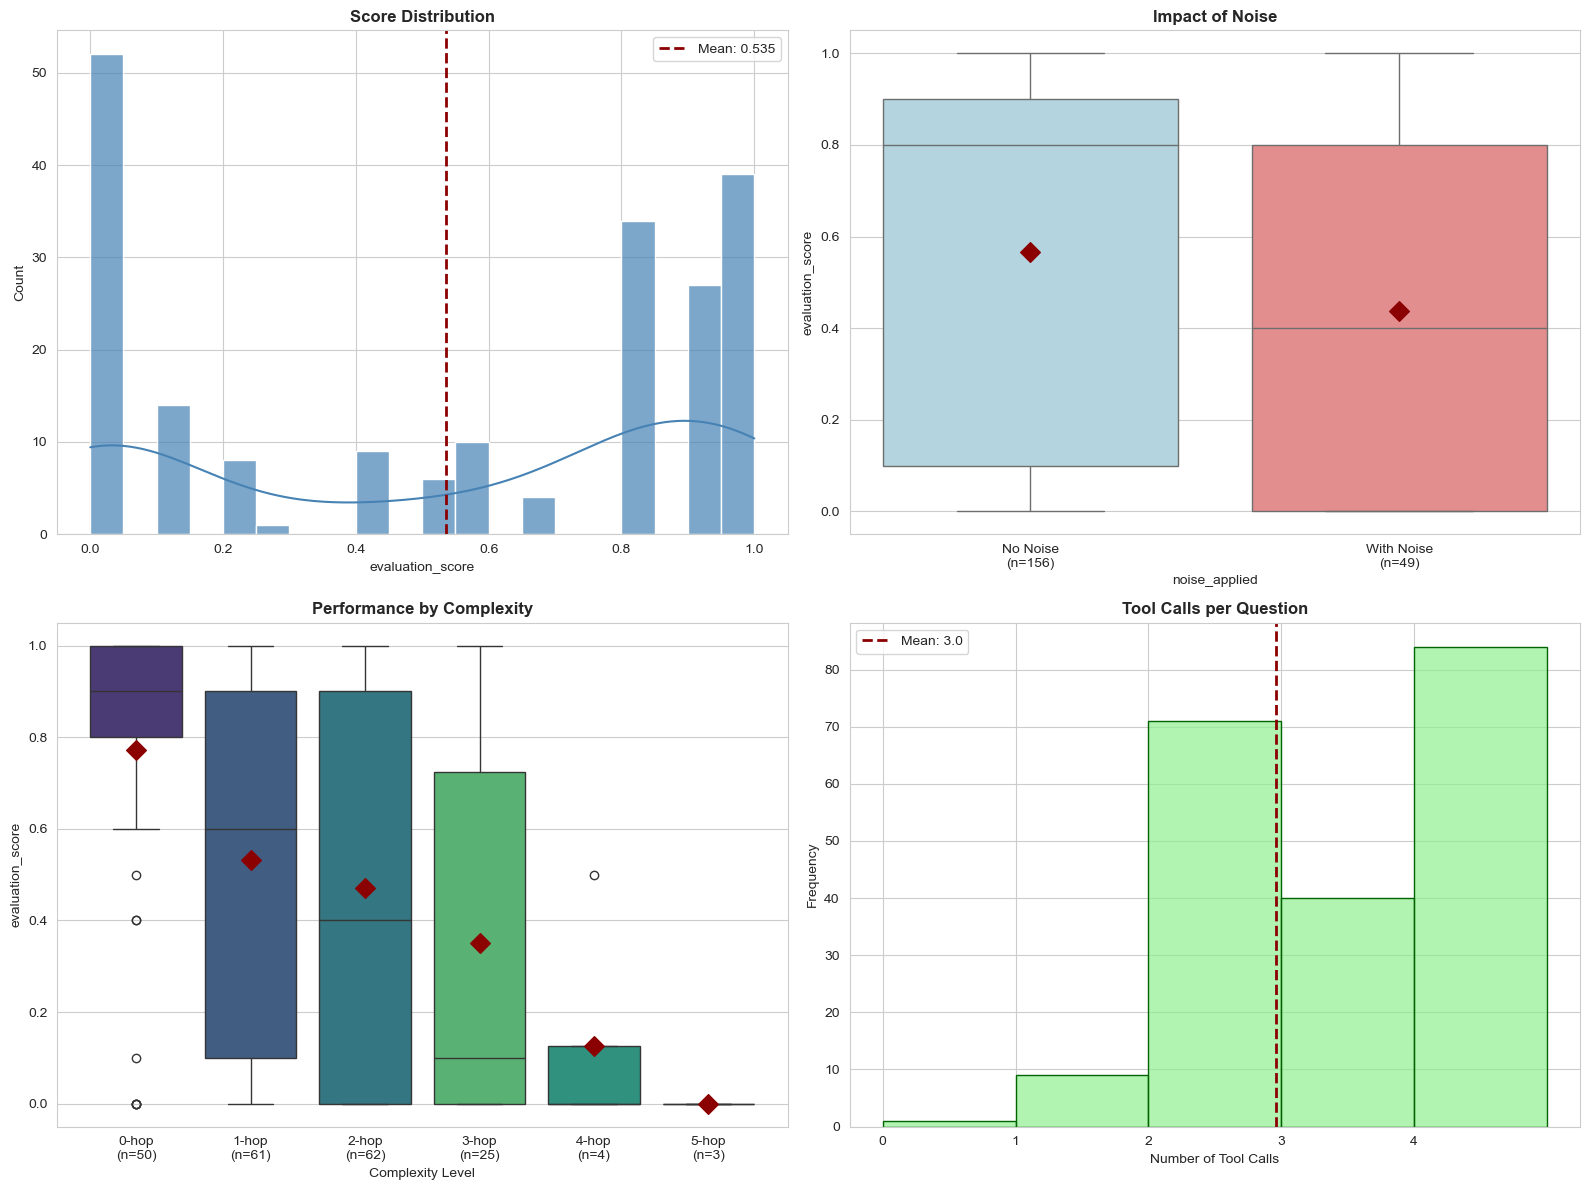


KEY COMPARISONS:
No Noise: 0.566 ± 0.401
With Noise: 0.437 ± 0.405

COMPLEXITY BREAKDOWN:
0-hop: 0.772 ± 0.295 (n=50.0)
1-hop: 0.533 ± 0.389 (n=61.0)
2-hop: 0.471 ± 0.419 (n=62.0)
3-hop: 0.350 ± 0.396 (n=24.0)
4-hop: 0.125 ± 0.250 (n=4.0)
5-hop: 0.000 ± 0.000 (n=3.0)

TOOL CALLS PER QUESTION:
  Mean: 2.96
  Median: 3.0
  Mode: 4
  Range: 0-4
  Std Dev: 0.99

Tool calls distribution:
  0 tools: 1 questions (0.5%)
  1 tools: 9 questions (4.4%)
  2 tools: 71 questions (34.6%)
  3 tools: 40 questions (19.5%)
  4 tools: 84 questions (41.0%)


In [7]:
evaluation_prompt = """You are an answer evaluation system. Compare the generated answer against the real answer and output only a single decimal score between 0 and 1.

Scoring criteria:
- 1.0: Generated answer is completely accurate and comprehensive
- 0.8-0.9: Mostly accurate with minor omissions or slight inaccuracies
- 0.6-0.7: Generally accurate but missing important details or contains some errors
- 0.4-0.5: Partially accurate with significant gaps or notable errors
- 0.2-0.3: Largely inaccurate with only some correct elements
- 0.0-0.1: Completely inaccurate or irrelevant

Consider both factual accuracy and completeness. Penalize hallucinations, contradictions, and missing key information.

Input format:
Question: {question}
Real answer: {reference}
Generated answer: {generated_answer}

Output format:
<reasoning>...</reasoning>
<score>0.4</score>
"""

result = await evaluate_mcp_agent(
    df,
    evaluation_prompt,
    agent_model="anthropic:claude-3-7-sonnet-latest",
    evaluation_model="openai:gpt-4o-mini",
)

In [8]:
result.to_csv("eval_results_default.csv", index=False)
result.head()

,question,cypher,query_type,complexity,noise_applied,model,database,validated,result,answer,noise_type,tools,generated_answer,evaluation_score,evaluation_reasoning,evaluation_raw,error,tool_count
0,What's Microsoft Corporation's revenue?,MATCH (o:Organization {name: 'Microsoft Corpor...,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'company_revenue': 198270000000.0}],"According to the data, Microsoft Corporation's...",No Noise,"[{'name': 'custom-get_neo4j_schema', 'args': {...","According to the database, Microsoft Corporati...",0.9,The generated answer accurately reflects the r...,<reasoning>The generated answer accurately ref...,NaN,2
1,How many employees does SAP have?,MATCH (o:Organization {name: 'SAP'}) RETURN o....,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'employee_count': 111961}],"According to the data, SAP has 111,961 employees.",No Noise,"[{'name': 'custom-get_neo4j_schema', 'args': {...","According to the data in the Neo4j database, S...",0.8,"The generated answer is factually accurate, pr...",<reasoning>The generated answer is factually a...,NaN,2
2,Tell me Mircosoft Corporation's motto,MATCH (o:Organization {name: 'Microsoft Corpor...,Direct Property Access,0-hop,True,anthropic-chat,companies,True,[{'company_motto': 'We’re on a mission to empo...,"Microsoft Corporation's motto is: ""We're on a ...",typo,"[{'name': 'custom-get_neo4j_schema', 'args': {...","Microsoft Corporation's motto is: ""We're on a ...",1.0,The generated answer matches the real answer e...,<reasoning>The generated answer matches the re...,NaN,2
3,Is Cloud Sherpas still active?,MATCH (o:Organization {name: 'Cloud Sherpas'})...,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'is_dissolved': True}],"No, Cloud Sherpas is not still active. The que...",No Noise,"[{'name': 'custom-get_neo4j_schema', 'args': {...",Based on the information retrieved from the Ne...,0.4,The generated answer contains accurate informa...,<reasoning>The generated answer contains accur...,NaN,4
4,What's the revenue of New Energy Group?,MATCH (o:Organization {name: 'New Energy Group...,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'company_revenue': 120000000.0}],"The revenue of New Energy Group is $120,000,000.",No Noise,"[{'name': 'custom-get_neo4j_schema', 'args': {...","According to the database, New Energy Group ha...",1.0,The generated answer accurately reflects the r...,<reasoning>The generated answer accurately ref...,NaN,2


Processing 35 records for database: companies
Processing 41 records for database: twitch
Error processing record: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'prompt is too long: 208471 tokens > 200000 maximum'}}
Error processing record: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'prompt is too long: 205272 tokens > 200000 maximum'}}
Processing 41 records for database: network
Error processing record: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT
Processing 48 records for database: northwind
Processing 40 records for database: ClinicalKnowledgeGraph
Error processing record: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'prompt is too long: 215232 tokens > 20

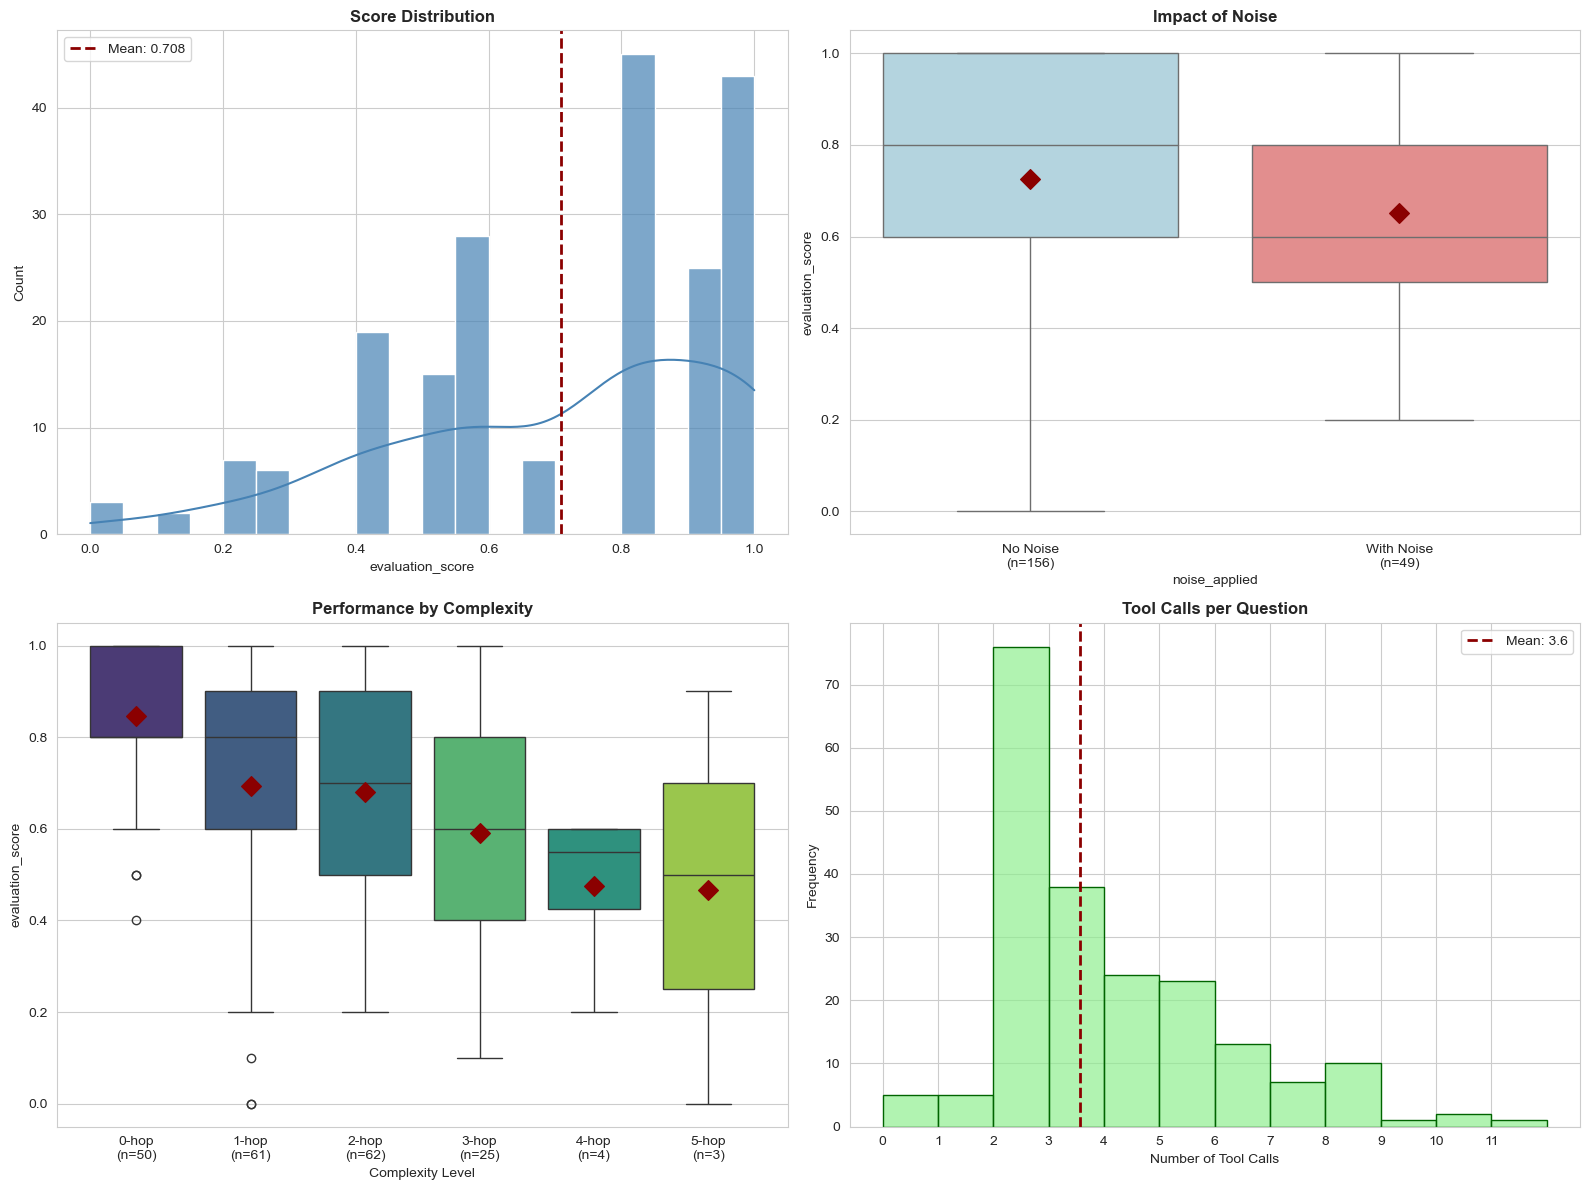


KEY COMPARISONS:
No Noise: 0.726 ± 0.260
With Noise: 0.651 ± 0.224

COMPLEXITY BREAKDOWN:
0-hop: 0.846 ± 0.149 (n=50.0)
1-hop: 0.693 ± 0.274 (n=60.0)
2-hop: 0.680 ± 0.240 (n=61.0)
3-hop: 0.591 ± 0.276 (n=22.0)
4-hop: 0.475 ± 0.189 (n=4.0)
5-hop: 0.467 ± 0.451 (n=3.0)

TOOL CALLS PER QUESTION:
  Mean: 3.56
  Median: 3.0
  Mode: 2
  Range: 0-11
  Std Dev: 2.07

Tool calls distribution:
  0 tools: 5 questions (2.4%)
  1 tools: 5 questions (2.4%)
  2 tools: 76 questions (37.1%)
  3 tools: 38 questions (18.5%)
  4 tools: 24 questions (11.7%)
  5 tools: 23 questions (11.2%)
  6 tools: 13 questions (6.3%)
  7 tools: 7 questions (3.4%)
  8 tools: 10 questions (4.9%)
  9 tools: 1 questions (0.5%)
  10 tools: 2 questions (1.0%)
  11 tools: 1 questions (0.5%)


In [9]:
recursion_result = await evaluate_mcp_agent(
    df,
    evaluation_prompt,
    agent_model="anthropic:claude-3-7-sonnet-latest",
    evaluation_model="openai:gpt-4o-mini",
    recursion_limit=25
)